In [1]:
import numpy as np
import eagle_constants_and_units as c
import cosmo_utils as csu
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mpl_toolkits.axes_grid1 as axgrid
from astropy import constants as const
from astropy import units as u
%matplotlib inline

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Get idea of surface brightness (SB) in H$\alpha$ to expect.  

Resolution:  The simulation resolution (32000x32000pixels in 100Mpc box) is 3.125kpc.  At redshift z = 0.1/0.01, the telescope angular resolution of 2.8" corresponds to a spatial resolution of 5.2kpc/0.6kpc.  

At the lower redshift, the telescope resolution is less than the simulation resolution, so it doesn't make sense to consider the full telescope resolution.  To match up to the simulation resolution, we need to bin by 3.125kpc/0.6kpc =~ 5.2 times (in each spatial direction).  To be consistent with the higher redshift simulation, we should match up our spatial resolution to that one: 5.2/0.6 =~ 9.

Note that this is somewhat arbitrary, though, because we just picked a redshift of 0.01 to put the galaxies at some distance from us, but the simulation is actually run at z = 0.00, so it's even closer than that.  To make things even, then, why don't we just do the initial binning at 10x10 (and say that that's a close enough match to the redshift z = 0.1 with no binning spatial resolution).

In [2]:
def imreduce(img, factor, log=True, method = 'average'):
    """
    img: 2D image array
    factor: factor by which to reduce the number of array elements along each axis
    log: whether or not the array contains log data values
    """
    if log:
        inimg = 10**img
    else:
        inimg = img
    inshape = np.array(img.shape)

    if np.sum(inshape%factor) != 0:
        print('Output grid must have a integer number of cells: cannot reduce image pixels by a factor %i'%factor)
        return None
    inimg = np.array(np.split(inimg,inshape[0]/factor,axis=0))
    inimg = np.array(np.split(inimg,inshape[1]/factor,axis=-1))

    inimg = np.sum(inimg,axis=-1)
    inimg = np.sum(inimg,axis=-1)

    if method == 'average':
        inimg = inimg/np.float(factor**2)
        #outimg = np.average(inimg[])
    if log:
        inimg = np.log10(inimg)
    return inimg.T

In [3]:
def makemap(data,size,ax,xystarts = [0.,0.]):
    fontsize=13
    #xystarts = [0.,0.] # lower left origin of the plot

    #fig = plt.figure(figsize = (5.5, 5.)) # large size just as a trick to get higher resolution
    #fig = plt.figure(figsize = (11., 10.))
    #ax = plt.subplot(111)
    ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
    ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
    ax.minorticks_on()
    ax.tick_params(labelsize=fontsize)

    colmap = 'viridis' #'afmhot'
    ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value


    img = ax.imshow(data.T,extent=(xystarts[0],xystarts[0]+size,xystarts[1],xystarts[1]+size),origin='lower', cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')

    #title = ''
    #plt.title(title,fontsize=fontsize)
    div = axgrid.make_axes_locatable(ax)
    cax = div.append_axes("right",size="5%",pad=0.1)
    cbar = plt.colorbar(img, cax=cax)

    cbar.solids.set_edgecolor("face")
    cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    
    return img
    #plt.show()

In [4]:
def indices_region(xbox,ybox):
# Tested in Eagle.ipynb on coho

# Create 2d arrays for both x and y indices values to pick out the data in the regions 
#(not sure, there's probably a better way to do this...)

#[53,53,56,56,53],[9.2,10,8.5,7.7,9.2]
#xbox = [53, 53, 56,56] # lower left, upper left, upper right, lower right
#ybox = [9.2,10,8.5,7.7] # lower left, upper left, upper right, lower right

#    xbox = [1,10,10,1] # lower left, upper left, upper right, lower right
#    ybox = [20,15,25,30]

#xacross_length = np.abs(xbox[2] - xbox[1])  
#xdown_length = np.abs(xbox[1]-xbox[0])       
#yacross_length = np.abs(ybox[2] - ybox[1])  
#ydown_length = np.abs(ybox[1]-ybox[0])         
    xacross_length = (xbox[2] - xbox[1])  
    xdown_length = (xbox[1]-xbox[0])       
    yacross_length = (ybox[2] - ybox[1])  
    ydown_length = (ybox[1]-ybox[0])   
    print('xacross_length,yacross_length,xdown_length,ydown_length:  '+str(xacross_length)+', '+
          str(yacross_length)+', '+str(xdown_length)+', '+str(ydown_length))

    if xacross_length > yacross_length:
        iterable = np.round(np.arange(xacross_length+1)*float(yacross_length)/float(xacross_length))
        yacross = [ybox[1]+y for y in iterable.astype(int)]
        xacross = [xbox[1]+x for x in xrange(xacross_length+1)]
        print('xacross_length > yacross_length:')
        print('iterable: '+str(iterable))
    elif xacross_length < yacross_length:
        iterable = np.round(np.arange(yacross_length+1)*float(xacross_length)/float(yacross_length))
        xacross = [xbox[1]+x for x in iterable.astype(int)]
        yacross = [ybox[1]+y for y in xrange(yacross_length+1)]
        print('xacross_length < yacross_length:')
        print('iterable: '+str(iterable))
    else:
        xacross = [xbox[1]+x for x in xrange(xacross_length+1)]
        yacross = [ybox[1]+y for y in xrange(yacross_length+1)]
        print('xacross_length = yacross_length')

    if xdown_length > ydown_length:
        iterable = np.round(np.arange(xdown_length+1)*float(ydown_length)/float(xdown_length))
        yfull = [np.array(yacross)-y for y in iterable.astype(int)]    
        xfull = [np.array(xacross)-x for x in xrange(xdown_length+1)]
        print('xdown_length > ydown_length:')
        print('iterable: '+str(iterable))    
    elif xdown_length < ydown_length:
        iterable = np.round(np.arange(ydown_length+1)*float(xdown_length)/float(ydown_length))
        xfull = [np.array(xacross)-x for x in iterable.astype(int)]
        yfull = [np.array(yacross)-y for y in xrange(ydown_length+1)]
        print('xdown_length < ydown_length:')
        print('iterable: '+str(iterable))    
    else:
        xfull = [np.array(xacross)-x for x in xrange(xdown_length+1)]
        yfull = [np.array(yacross)-y for y in xrange(ydown_length+1)]
        print('xdown_length = ydown_length:')

    xfull = np.array(xfull)
    yfull = np.array(yfull)
    
    return xfull, yfull

In [5]:
def Dragonfly():
    area_lens = np.pi*(14.3/2)**2 * 48. * u.cm**2               # 48 * 14.3 cm diameter lenses
    pix_size = 2.8                                              # arcsec
    ang_size_pixel  = (pix_size * (1./206265.))**2 * u.rad**2   # rad^2, the pixel size of the CCD

    tau_l = 0.85  # transmittance of the Dragonfly lens
    QE = 0.48     # quantum efficiency of the CCDs
    tau_f = 1.    # transmittance of the Halpha filter -- assumed for now

    # The following are per pixel
    B = 0.52135 *u.photon/u.second/u.nm/u.arcsec**2/u.m**2  # sky background at 565.6 nm 
    D = 0.04 *u.photon/u.second                             # dark current (electrons / s) -- PER PIXEL??
    R_squared = 10.**2 * u.photon                           # read noise (electrons)

    return [area_lens, ang_size_pixel, pix_size, tau_l, tau_f, QE, B, D, R_squared]



Load the simulation: 

In [6]:
# Where is this running
machine= "coho"  # "coho" or "chinook"

# Data parameters
factor = 10  # Factor by which immediately bin the simulation. reduces the number of pixels to 32000/10 = 3200 
# Do this to get rid of high and low value random pixels
Vmin = None
Vmax= None
xystarts=None
sl = [slice(None,None,None), slice(None,None,None)]

## Simulation snapnum 27 (z = 0.1), xy box size: 100Mpc, z slice width: 5Mpc, zloc: 12.5Mpc
#file_SFonly = '/Users/lokhorst/Eagle/emission_halpha_L0100N1504_27_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz'
#file_noSF = '/Users/lokhorst/Eagle/emission_halpha_L0100N1504_27_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz'

# Simulation snapnum 28 (z = 0), xy box size: 100Mpc, z slice width: 5Mpc, zloc: 12.5Mpc
if machine =="chinook":
    file_SFonly = '/Users/lokhorst/Eagle/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz'
    file_noSF = '/Users/lokhorst/Eagle/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz'
elif machine =="coho":
    file_SFonly = '/Users/deblokhorst/eagle/SlicesFromNastasha/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5__fromSFR.npz'
    file_noSF = '/Users/deblokhorst/eagle/SlicesFromNastasha/emission_halpha_L0100N1504_28_test2_SmAb_C2Sm_32000pix_5.000000slice_zcen12.5_noSFR.npz'

In [7]:
# Load star-forming Halpha emission data
data_SFonly = (np.load(file_SFonly)['arr_0'])[sl]
data_SFonly = imreduce(data_SFonly, factor, log=True, method = 'average')

/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:26: RuntimeWarning: divide by zero encountered in log10


In [8]:
# Load non-star-forming Halpha emission data
data_noSF = (np.load(file_noSF)['arr_0'])[sl]
data_noSF = imreduce(data_noSF, factor, log=True, method = 'average')

In [9]:
# Add together SFing and non-SFing Halpha emission data
data_total = np.log10(10**data_SFonly+10**data_noSF)
del data_noSF
del data_SFonly

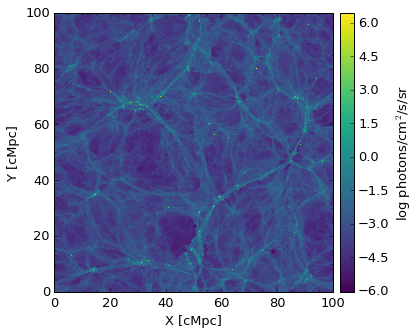

In [11]:
# Plotting parameters
fontsize=13
size = 100 # side length of the projection we are plotting (can be full 100 or just a portion)
xystarts = [0.,0.] # lower left origin of the plot
clabel = r'log photons/cm$^2$/s/sr'

fig = plt.figure(figsize = (6.5, 5.))
ax1 = plt.subplot(111)
#ax2 = plt.subplot(122)
makemap(data_total,size,ax1,xystarts = [0.,0.])
#makemap(dataT,size,ax2,xystarts = [0.,0.])
#plt.savefig('plots/Eagle_fullsimulationbox_5Mpcsplice.pdf')

In [32]:
import eagleSqlTools as sql

mySim = ('RefL0100N1504',100.)
con   = sql.connect("dlokhorst",password="mxdPB54Y")  

myQuery  = "SELECT \
                SH.GalaxyID, \
                SH.CentreOfMass_x, \
                SH.CentreOfMass_y, \
                SH.CentreOfMass_z, \
                SH.StarFormationRate as SFR \
            FROM \
                %s_SubHalo as SH \
            WHERE \
                SH.SnapNum = 28 and \
                SH.StarFormationRate > 0.00001 "%('RefL0100N1504')

myData = sql.execute_query(con,myQuery)

x = myData['CentreOfMass_x'][:]
y = myData['CentreOfMass_y'][:]
z = myData['CentreOfMass_z'][:]
SFR = myData['SFR'][:]
x_inbox = x[(x < 60.) & (x > 40.) & (y < 20.) & (y > 0.) & (z < 15.) & (z > 10.)]
y_inbox = y[(x < 60.) & (x > 40.) & (y < 20.) & (y > 0.) & (z < 15.) & (z > 10.)]
z_inbox = z[(x < 60.) & (x > 40.) & (y < 20.) & (y > 0.) & (z < 15.) & (z > 10.)]
SFR_inbox = SFR[(x < 60.) & (x > 40.) & (y < 20.) & (y > 0.) & (z < 15.) & (z > 10.)]

print(len(SFR_inbox[SFR_inbox<1.]))
print(len(SFR_inbox[SFR_inbox<0.1]))
print(len(SFR_inbox[SFR_inbox<0.01]))

210
174
63


Pick out locations where want to extract the surface brightness.

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


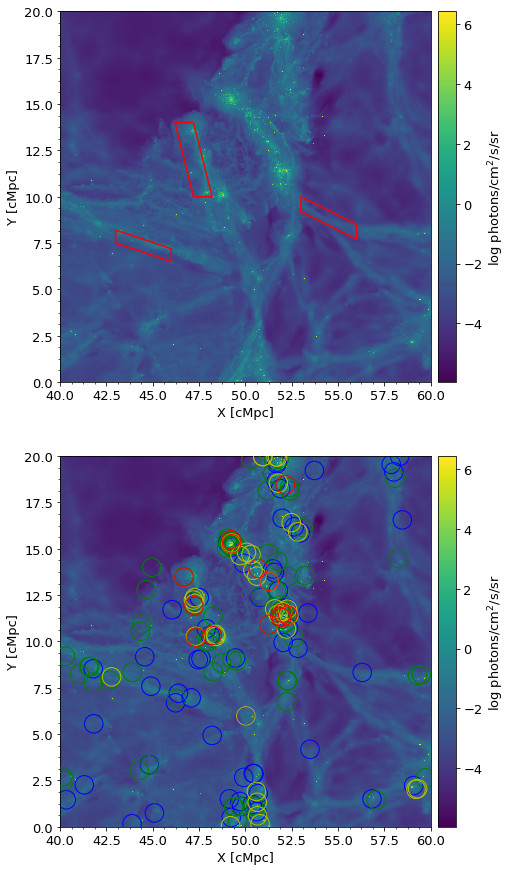

In [33]:
xystarts = [40.,0.]  
size     = 20.       

fig = plt.figure(figsize = (16.5, 15.))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
makemap(data_noSF[(40./100.*3200.):(60./100.*3200.),0:(20./100.*3200.)],size,ax1,xystarts = xystarts)
makemap(data_total[(40./100.*3200.):(60./100.*3200.),0:(20./100.*3200.)],size,ax2,xystarts = xystarts)

# Circle SFing regions 
for i in range(len(x_inbox)):
    if SFR_inbox[i] > 1.0:
        color = 'r'
        zorder = 5
    elif SFR_inbox[i] > 0.1:
        color = 'y'
        zorder = 4
    elif SFR_inbox[i] > 0.01:
        color = 'g'
        zorder = 3
    else:
        color = 'b'
        zorder = 2
    circle1 = plt.Circle((x_inbox[i],y_inbox[i]), 0.5, color=color,fill=False,zorder=zorder)
    ax2.add_artist(circle1)
    
# Pick out regions along the filaments in the map
ax1.plot([53,53,56,56,53],[9.2,10,8.5,7.7,9.2],color='r')
ax1.plot(np.array([46.2,47.2,48.2,47.2,46.2]),[14,14,10,10,14],color='r')
ax1.plot(np.array([43,43,46,46,43]),[7.5,8.2,7.2,6.5,7.5],color='r')

Use the regions in the map above to get estimates of the surface brightness along the filaments.  Then we can use these surface brightnesses to estimate the exposure times required to image them.

In [13]:
# Regions selected in map above:
xbox = np.array([47.4,46.2,46.9,48.1])*3200./100.
ybox = np.array([10.5,14,14,10.5])*3200./100.
#xbox = np.array([43,43,46,46])*3200./100.
#ybox = np.array([7.5,8.2,7.2,6.5])*3200./100.
#xbox = np.array([53,53,56,56])*3200./100.
#ybox = np.array([9.2,10,8.5,7.7])*3200./100.

print(xbox,ybox)
print(xbox.astype(int),ybox.astype(int))
xfull, yfull= indices_region(xbox.astype(int),ybox.astype(int))

print((46.9/100.*3200.)-(46.2/100.*3200.))
print((48.1/100.*3200.)-(47.4/100.*3200.))
print((14./100.*3200.)-(10.5/100.*3200.))
print(xfull.shape)

# Cycle through the arrays, spitting out the pairs of indices that we want to sum up over. (now unneccesary)
#SBarray = []
#for x,y in zip(xfull,yfull):
#    for i,j in zip(x,y):
#        #print i,j
#        SBarray.append(data_noSF[x,y])
#SBarray = np.array(SBarray)
#averageSB = np.log10(np.mean(10**SBarray))
#totalSB = np.log10(np.sum(10**SBarray))

# Cycle through the x and y arrays, and put the SB data into a new array
SBdata = np.zeros(xfull.shape)
for i in range(yfull.shape[0]):
    for j in range(yfull.shape[1]):
        SBdata[i,j] = data_noSF[xfull[i,j],yfull[i,j]]

SBdata_average = np.log10(np.mean(10**SBdata))
SBdata_median  = np.median(SBdata)
print('Average SB in the selected region: '+str(SBdata_average))
print('Median SB in the selected region:'+str(SBdata_median))


(array([ 1516.8,  1478.4,  1500.8,  1539.2]), array([ 336.,  448.,  448.,  336.]))
(array([1516, 1478, 1500, 1539]), array([336, 448, 448, 336]))
xacross_length,yacross_length,xdown_length,ydown_length:  22, 0, -38, 112
xacross_length > yacross_length:
iterable: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]
xdown_length < ydown_length:
iterable: [ -0.  -0.  -1.  -1.  -1.  -2.  -2.  -2.  -3.  -3.  -3.  -4.  -4.  -4.  -5.
  -5.  -5.  -6.  -6.  -6.  -7.  -7.  -7.  -8.  -8.  -8.  -9.  -9. -10. -10.
 -10. -11. -11. -11. -12. -12. -12. -13. -13. -13. -14. -14. -14. -15. -15.
 -15. -16. -16. -16. -17. -17. -17. -18. -18. -18. -19. -19. -19. -20. -20.
 -20. -21. -21. -21. -22. -22. -22. -23. -23. -23. -24. -24. -24. -25. -25.
 -25. -26. -26. -26. -27. -27. -27. -28. -28. -28. -29. -29. -30. -30. -30.
 -31. -31. -31. -32. -32. -32. -33. -33. -33. -34. -34. -34. -35. -35. -35.
 -36. -36. -36. -37. -37. -37. -38. -38.]
22.4
22.4
112.0
(113, 23)
Ave

(array([ 1376.,  1376.,  1472.,  1472.]), array([ 248. ,  254.4,  225.6,  216. ]))
(array([1376, 1376, 1472, 1472]), array([248, 254, 225, 216]))
xacross_length,yacross_length,xdown_length,ydown_length:  96, -29, 0, 6
xacross_length > yacross_length:
iterable: [ -0.  -0.  -1.  -1.  -1.  -2.  -2.  -2.  -2.  -3.  -3.  -3.  -4.  -4.  -4.
  -5.  -5.  -5.  -5.  -6.  -6.  -6.  -7.  -7.  -7.  -8.  -8.  -8.  -8.  -9.
  -9.  -9. -10. -10. -10. -11. -11. -11. -11. -12. -12. -12. -13. -13. -13.
 -14. -14. -14. -14. -15. -15. -15. -16. -16. -16. -17. -17. -17. -18. -18.
 -18. -18. -19. -19. -19. -20. -20. -20. -21. -21. -21. -21. -22. -22. -22.
 -23. -23. -23. -24. -24. -24. -24. -25. -25. -25. -26. -26. -26. -27. -27.
 -27. -27. -28. -28. -28. -29. -29.]
xdown_length < ydown_length:
iterable: [ 0.  0.  0.  0.  0.  0.  0.]
-96.0
-6.4
6.4
(7, 97)
Max SB in the selected region: 5.43813610077
Average SB in the selected region: 2.60640495552
Median SB in the selected region:-2.13998365402


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:63: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


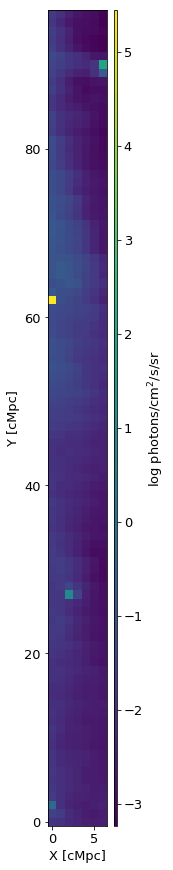

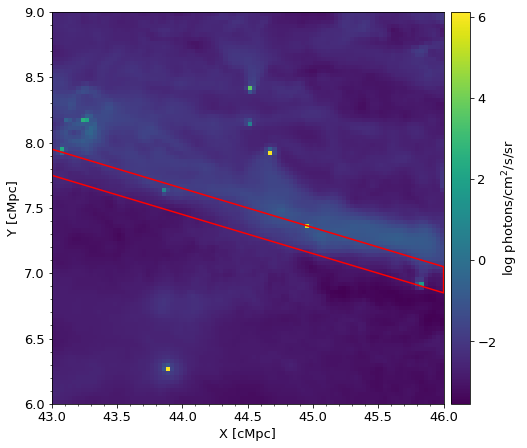

In [14]:
# Regions selected in map above:
#xbox = np.array([47.2,46.2,47.2,48.2])*3200./100.
#ybox = np.array([10,14,14,10])*3200./100.
xbox = np.array([43,43,46,46])*3200./100.
ybox = (np.array([7.8,8.,7.1,6.8])-0.05)*3200./100.
#xbox = np.array([53,53,56,56])*3200./100.
#ybox = np.array([9.2,10,8.5,7.7])*3200./100.

print(xbox,ybox)
print(xbox.astype(int),ybox.astype(int))
xfull, yfull= indices_region(xbox.astype(int),ybox.astype(int))

print((43./100.*3200.)-(46./100.*3200.))
print((7.8/100.*3200.)-(8./100.*3200.))
print((7.1/100.*3200.)-(6.9/100.*3200.))
print(xfull.shape)
# Cycle through the arrays, spitting out the pairs of indices that we want to sum up over. (now unneccesary)
#SBarray = []
#for x,y in zip(xfull,yfull):
#    for i,j in zip(x,y):
#        #print i,j
#        SBarray.append(data_noSF[x,y])
#SBarray = np.array(SBarray)
#averageSB = np.log10(np.mean(10**SBarray))
#totalSB = np.log10(np.sum(10**SBarray))

# Cycle through the x and y arrays, and put the SB data into a new array
SBdata = np.zeros(xfull.shape)
for i in range(yfull.shape[0]):
    for j in range(yfull.shape[1]):
        SBdata[i,j] = data_noSF[xfull[i,j],yfull[i,j]]

SBdata_average = np.log10(np.mean(10**SBdata))
SBdata_median  = np.median(SBdata)
SBdata_max     = np.max(SBdata)
print('Max SB in the selected region: '+str(SBdata_max))
print('Average SB in the selected region: '+str(SBdata_average))
print('Median SB in the selected region:'+str(SBdata_median))

# Plot the data that we've pulled out from the array as a check
fig = plt.figure(figsize = (16.5, 15.))
ax = plt.subplot(121)
fontsize=13
xystarts = [0.,0.] # lower left origin of the plot
ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
colmap = 'viridis' #'afmhot'
ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
img = ax.imshow(SBdata.T,origin='lower', cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')
div = axgrid.make_axes_locatable(ax)
cax = div.append_axes("right",size="5%",pad=0.1)
cbar = plt.colorbar(img, cax=cax)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Plot the original data around the region we pulled out to do a cross-check
fig = plt.figure(figsize = (16.5, 15.))
ax1 = plt.subplot(121)
size = 3.0
xystarts = [43.,6.]
makemap(data_noSF[(43./100.*3200.):(46./100.*3200.),(6./100.*3200.):(9./100.*3200.)],size,ax1,xystarts = xystarts)
ax1.plot(np.array([43,43,46,46,43]),np.array([7.8,8.,7.1,6.9,7.8])-0.05,color='r')
plt.show()

(array([ 1696.,  1696.,  1792.,  1792.]), array([ 294.4,  320. ,  272. ,  246.4]))
(array([1696, 1696, 1792, 1792]), array([294, 320, 272, 246]))
xacross_length,yacross_length,xdown_length,ydown_length:  96, -48, 0, 26
xacross_length > yacross_length:
iterable: [ -0.  -0.  -1.  -2.  -2.  -2.  -3.  -4.  -4.  -4.  -5.  -6.  -6.  -6.  -7.
  -8.  -8.  -8.  -9. -10. -10. -10. -11. -12. -12. -12. -13. -14. -14. -14.
 -15. -16. -16. -16. -17. -18. -18. -18. -19. -20. -20. -20. -21. -22. -22.
 -22. -23. -24. -24. -24. -25. -26. -26. -26. -27. -28. -28. -28. -29. -30.
 -30. -30. -31. -32. -32. -32. -33. -34. -34. -34. -35. -36. -36. -36. -37.
 -38. -38. -38. -39. -40. -40. -40. -41. -42. -42. -42. -43. -44. -44. -44.
 -45. -46. -46. -46. -47. -48. -48.]
xdown_length < ydown_length:
iterable: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.]
-96.0
25.6
-25.6
(27, 97)
Average SB in the selected region: -2.76385999157
Median SB in the se

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:67: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


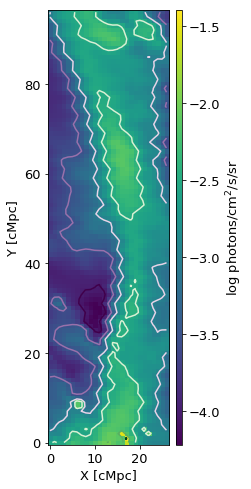

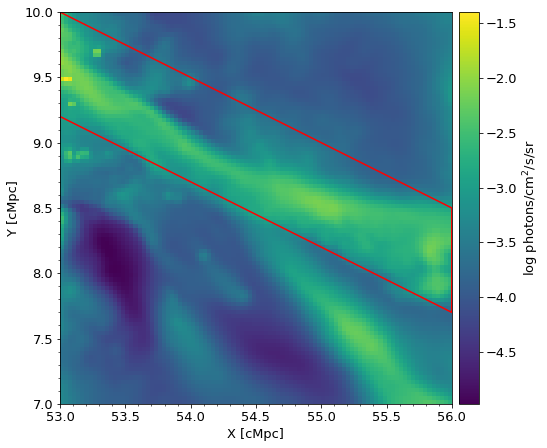

In [21]:
# Regions selected in map above:
#xbox = np.array([47.2,46.2,47.2,48.2])*3200./100.
#ybox = np.array([10,14,14,10])*3200./100.
#xbox = np.array([43,43,46,46])*3200./100.
#ybox = np.array([7.5,8.2,7.2,6.5])*3200./100.
xbox = np.array([53,53,56,56])*3200./100.
ybox = np.array([9.2,10,8.5,7.7])*3200./100.

print(xbox,ybox)
print(xbox.astype(int),ybox.astype(int))
xfull, yfull= indices_region(xbox.astype(int),ybox.astype(int))

print((53./100.*3200.)-(56./100.*3200.))
print((10./100.*3200.)-(9.2/100.*3200.))
print((7.7/100.*3200.)-(8.5/100.*3200.))
print(xfull.shape)
# Cycle through the arrays, spitting out the pairs of indices that we want to sum up over. (now unneccesary)
#SBarray = []
#for x,y in zip(xfull,yfull):
#    for i,j in zip(x,y):
#        #print i,j
#        SBarray.append(data_noSF[x,y])
#SBarray = np.array(SBarray)
#averageSB = np.log10(np.mean(10**SBarray))
#totalSB = np.log10(np.sum(10**SBarray))

# Cycle through the x and y arrays, and put the SB data into a new array
SBdata = np.zeros(xfull.shape)
for i in range(yfull.shape[0]):
    for j in range(yfull.shape[1]):
        SBdata[i,j] = data_noSF[xfull[i,j],yfull[i,j]]

SBdata_average = np.log10(np.mean(10**SBdata))
SBdata_median  = np.median(SBdata)
print('Average SB in the selected region: '+str(SBdata_average))
print('Median SB in the selected region:'+str(SBdata_median))

# Plot the data that we've pulled out from the array as a check
fig = plt.figure(figsize = (7.5, 8.))
ax = plt.subplot(121)
fontsize=13
xystarts = [0.,0.] # lower left origin of the plot
ax.set_xlabel(r'X [cMpc]',fontsize=fontsize)
ax.set_ylabel(r'Y [cMpc]',fontsize=fontsize)
ax.tick_params(labelsize=fontsize)
colmap = 'viridis' #'afmhot'
ax.patch.set_facecolor(cm.get_cmap(colmap)(0.)) # sets background color to lowest color map value
img = ax.imshow(SBdata.T,origin='lower', cmap=cm.get_cmap(colmap), vmin = Vmin, vmax=Vmax,interpolation='nearest')

cmap = cm.PRGn
levels = np.array([-4.,-3.5,-3.0,-2.5,-2.0,-1.5])
plt.contour(SBdata.T,levels,cmap=cm.get_cmap(cmap, len(levels) - 1),)


div = axgrid.make_axes_locatable(ax)
cax = div.append_axes("right",size="5%",pad=0.1)
cbar = plt.colorbar(img, cax=cax)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel(r'%s' % (clabel), fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# Plot the original data around the region we pulled out to do a cross-check
fig = plt.figure(figsize = (16.5, 15.))
ax1 = plt.subplot(121)
size = 3.0
xystarts = [53.,7.]
makemap(data_noSF[(53./100.*3200.):(56./100.*3200.),(7./100.*3200.):(10./100.*3200.)],size,ax1,xystarts = xystarts)
ax1.plot([53,53,56,56,53],[9.2,10.,8.5,7.7,9.2],color='r')
plt.show()

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:18: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


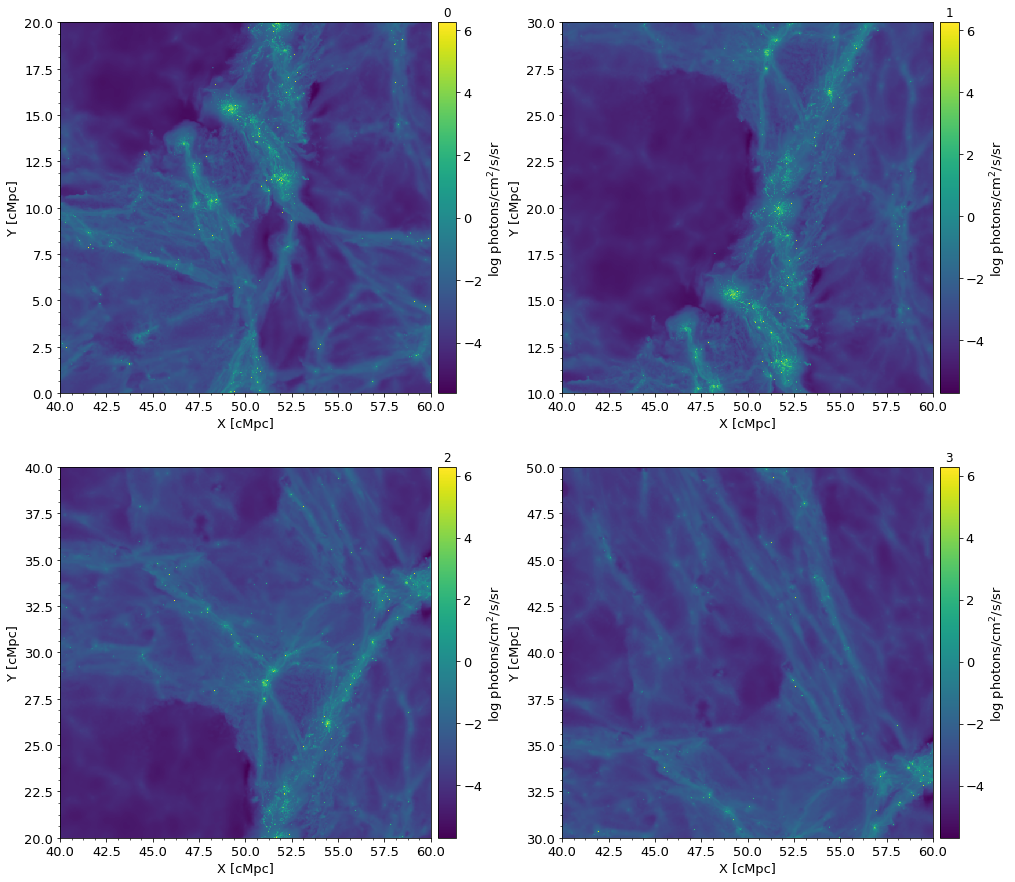

In [45]:
# Let's try and plot more regions to get inspired
xystarts = [40.,0.]  
xstart   = [40.,40.,40.,40.
ystart   = [0.,10.,20.,30.]
size     = 20.       
totalsize= 100.
numpix   = 3200.

fig = plt.figure(figsize = (16.5, 15.))
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)
axarr = [ax1,ax2,ax3,ax4]

for i in range(4):
    makemap(data_noSF[(xstart[i]/totalsize*numpix):((xstart[i]+size)/totalsize*numpix),
                      (ystart[i]/totalsize*numpix):((ystart[i]+size)/totalsize*numpix)],
            size,axarr[i],xystarts = [xstart[i],ystart[i]])
    plt.title(str(i))


In [54]:
(47.2/100.*3200.)-(48.2/100.*3200.)

-32.0

In [35]:
(10./100.*3200.)-(14./100.*3200.)

-128.00000000000006

In [17]:
10**2.639443

435.95634213062027